# 3차시

In [1]:
import tensorflow as tf
from glob import glob
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
data_paths = glob('dataset/mnist_png/training/0/*png') 
path = data_paths[0]
path

'dataset/mnist_png/training/0\\1.png'

In [3]:
data_paths = tf.io.matching_files('./dataset/mnist_png/training/*/*.png')   # 이건 tensor 내장기능
data_paths[0]

<tf.Tensor: shape=(), dtype=string, numpy=b'.\\dataset\\mnist_png\\training\\0\\1.png'>

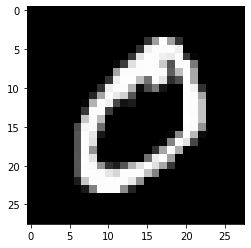

In [4]:
gfile = tf.io.read_file(path)
image = tf.io.decode_image(gfile)   # ndarray 꼴로 변경해줌
image.shape
plt.imshow(image[:, :, 0], 'gray')
plt.show()

## Data Generator

In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np 

In [6]:
datagen = ImageDataGenerator( #전처리할것들을 넣어주면됨 #Augmentation
    rotation_range = 20,    # 사진돌리기
    width_shift_range= 0.2,
    height_shift_range = 0.2,
    horizontal_flip = True
)


In [7]:
image.shape

inputs = image[tf.newaxis, ...]
inputs.shape

TensorShape([1, 28, 28, 1])

In [8]:
image = next(iter(datagen.flow(inputs)))  # Object객체에 있는 iter메소드를 이용하여 하나씩 엑세스할수있는 데이터타입으로 변환한뒤, next메소드를 이용하여 순서대로 하나씩 불러오기

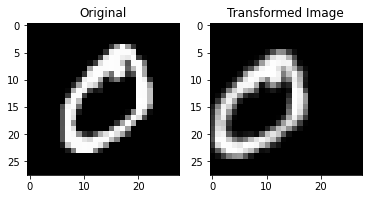

In [9]:
plt.subplot(121)
plt.title('Original')
plt.imshow(np.squeeze(inputs), 'gray')

plt.subplot(122)
plt.title('Transformed Image')
plt.imshow(np.squeeze(image), 'gray')

plt.show()

## Augmentation
### Transformation

- width_shift_range
- height_shift_range
- brightness_range
- zoom_range
- horizontal_flip
- vertical_flip
- rescale
- preprocessing_function // 커스터마이즈한 함수도 넣을수있다리~

> 주피터에선 Shift+Tab으로 함수 파라미터 확인 가능

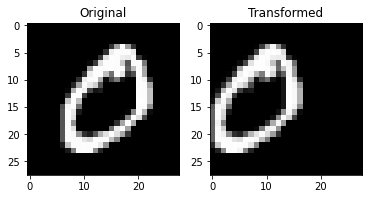

In [10]:
datagen = ImageDataGenerator(
    width_shift_range = 0.3
)

outputs = next(iter(datagen.flow(inputs)))

plt.subplot(121)
plt.title('Original')
plt.imshow(np.squeeze(inputs), 'gray')

plt.subplot(122)
plt.title('Transformed')
plt.imshow(np.squeeze(outputs), 'gray')

plt.show()

## Rescale시 주의사항 (Normalization)
> Zoom_range를 test에는 **적용시키면 안됨!**

In [11]:
train_datagen = ImageDataGenerator(
    zoom_range = 0.7,
    rescale = 1./255.
)

test_datagen = ImageDataGenerator(rescale = 1./255.)

# 4차시

In [12]:
import os
from glob import glob

import tensorflow as tf 
from tensorflow.keras import layers

from tensorflow.keras import datasets 
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [13]:
import numpy as np 
import matplotlib.pyplot as plt 
%matplotlib inline

이미지를 이미 로드하고 ImageDataGenerator의 flow를 이용하였는데,

그럴필요가 없다  

In [14]:
os.listdir('./dataset/mnist_png/training')

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

In [15]:
train_dir = './dataset/mnist_png/training'
test_dir = './dataset/mnist_png/testing'

## Hyperparameter Tunning

In [16]:
num_epochs = 10
batch_size = 32

learning_rate = 0.001

dropout_rate = 0.7

input_shape = (28, 28, 1)
num_classes = 10

## Preprocess

In [17]:
train_datagen = ImageDataGenerator(
    rescale=1./255.,
    width_shift_range=0.3,
    zoom_range=0.2,
    horizontal_flip=True
)

test_datagen = ImageDataGenerator(
    rescale=1./255. # Rescale은 남겨놔야함!
)

In [19]:
train_generator = train_datagen.flow_from_directory( # 아까처럼 미리 불러다가 flow에 넣을필요없이 이렇게 바로 부를수도있음
    train_dir,
    #클래스를 2개 나중에 더 넣긴할거다 하면, classes 매개변수 설정
    target_size=input_shape[:2], #채널까진 넣어줄필요없음
    batch_size=batch_size,
    color_mode='grayscale',
    class_mode='categorical' # Binary일때는 바꿔줘야함
)

Found 60000 images belonging to 10 classes.


In [20]:
validation_generator = test_datagen.flow_from_directory( # 아까처럼 미리 불러다가 flow에 넣을필요없이 이렇게 바로 부를수도있음
    test_dir,
    target_size=input_shape[:2], #채널까진 넣어줄필요없음
    batch_size=batch_size,
    color_mode='grayscale',
    class_mode='categorical' # Binary일때는 바꿔줘야함
)

Found 10000 images belonging to 10 classes.


## Build Model

In [24]:
inputs = layers.Input(input_shape)
net = layers.Conv2D(32, (3, 3), padding='SAME')(inputs)
net = layers.Activation('relu')(net)
net = layers.Conv2D(32, (3, 3), padding='SAME')(inputs)
net = layers.Activation('relu')(net)
net = layers.MaxPooling2D(pool_size=(2, 2))(net)
net = layers.Dropout(dropout_rate)(net)

net = layers.Conv2D(64, (3, 3), padding='SAME')(net)
net = layers.Activation('relu')(net)
net = layers.Conv2D(64, (3, 3), padding='SAME')(net)
net = layers.Activation('relu')(net)
net = layers.MaxPooling2D(pool_size=(2, 2))(net)
net = layers.Dropout(dropout_rate)(net)

net = layers.Flatten()(net)
net = layers.Dense(512)(net)
net = layers.Activation('relu')(net)
net = layers.Dropout(dropout_rate)(net)
net = layers.Dense(num_classes)(net)
net = layers.Activation('softmax')(net)

model = tf.keras.Model(inputs=inputs, outputs=net, name='Basic_CNN')

In [25]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate),
                        loss = 'categorical_crossentropy',
                        metrics = ['accuracy'])

## Training

In [27]:
# 기존에는 fit만했다면, 지금 우리는 generator를 이용할거기때문에, fit_generator 사용

# fit(x, y, ...)
# fit_generator(generator, ...)

model.fit_generator(
    train_generator,
    steps_per_epoch=len(train_generator), # 한 epoch에 batch 몇개가 도는지 설정해줘야하는데 이렇게 넣어주믄 됨
    epochs = num_epochs,
    validation_data = validation_generator,
    validation_steps = len(validation_generator)
)


NameError: name 'validationn_generator' is not defined